In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import glob
import math

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

In [2]:
window_size = 100

def moving_average(x, window_size=window_size):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')


def find_sign_change_step(steps, values):
    # Compute numerical derivative
    derivatives = np.diff(values)
    signs = np.sign(derivatives)

    # Look for sign changes
    for i in range(1, len(signs)):
        if signs[i] != 0 and signs[i] != signs[i - 1]:
            return steps[i + window_size - 1]  # Adjust index because of moving average window
    return None


def find_large_positive_derivative_step(steps, values, threshold=0.008):
    derivatives = np.diff(values)
    for i, d in enumerate(derivatives):
        if d > threshold:
            return float(steps[i + 1])
    return None

In [3]:

ratios = {}
ratios['fp6_e2m3_fp6_e3m2'] = [9.73842, 16.23425, 62.08117, 83.29887, 113.2144, 156.01372]
ratios['fp6_e3m2_fp6_e3m2'] = [42.36739, 62.40892, 93.80541, 144.13805]
# ratios['fp8_e4m3_fp8_e4m3'] = [42.36739, 62.40892, 93.80541, ]

In [4]:
choice = 'fp6_e2m3_fp6_e3m2'
csv_files = glob.glob(f"data/training_loss/{choice}/*.csv")  

[5.05078125 4.3046875  4.1640625  ... 2.33984375 2.38574219 2.33984375]
smoothed [2.89368164 2.86678711 2.84720703 ... 2.30689453 2.30776367 2.30822266]
[5.43164062 4.37695312 4.21484375 ... 2.59082031 2.59082031 2.59765625]
smoothed [2.98121094 2.95132813 2.93177734 ... 2.60586914 2.60571289 2.60581055]
[5.0546875  4.34179688 4.22851562 ... 5.09375    5.01953125 5.0625    ]
smoothed [3.01078125 2.98579102 2.96768555 ... 4.61262695 4.61930664 4.62661133]
[5.08007812 4.3671875  4.25       ... 5.9609375  5.96875    5.984375  ]
smoothed [3.04848633 3.02356445 3.005625   ... 5.98695312 5.98705078 5.98726563]
[4.88476562 4.36523438 4.26171875 ... 6.23632812 4.28515625 4.10253906]
smoothed [3.02392578 3.0006543  2.98280273 ... 5.04900391 5.03935547 5.02352539]
[4.58789062 4.37304688 4.28125    ... 6.08398438 6.11132812 6.140625  ]
smoothed [3.09355469 3.07422852 3.05693359 ... 5.22244141 5.22138672 5.22121094]


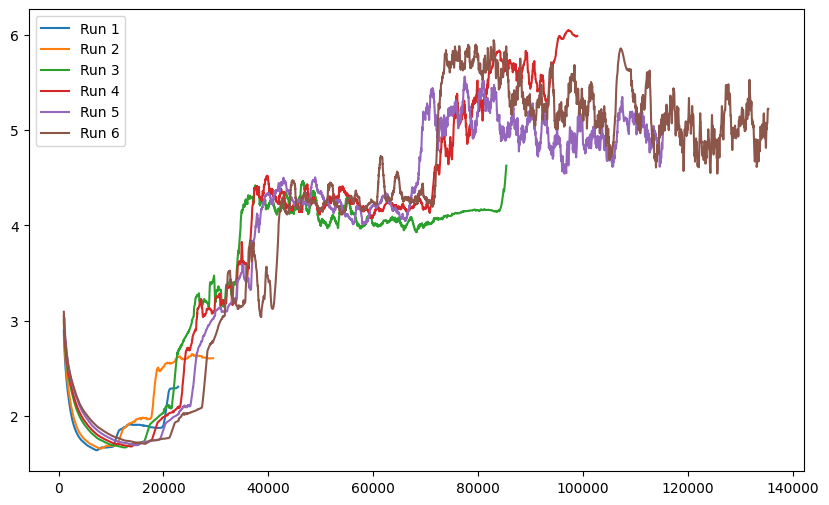

In [5]:
results = []

plt.figure(figsize=(10, 6))
for idx, file in enumerate(sorted(csv_files)):
    df = pd.read_csv(file)

    step_col = "Step"
    loss_col = [col for col in df.columns if "CrossEntropyLoss" in col and "__" not in col][0]

    steps = df[step_col].astype(float).values
    losses = df[loss_col].astype(float).values
    print(losses)
    smoothed = moving_average(losses, window_size)
    print('smoothed', smoothed)
    smoothed_steps = steps[window_size - 1:]  # Align with moving average

    sign_change_step = find_large_positive_derivative_step(smoothed_steps, smoothed)
    results.append(sign_change_step)

    label = f"Run {idx + 1}"
    plt.plot(smoothed_steps, smoothed, label=label)

plt.legend()

In [6]:
results

[None, 14660.0, 20080.0, 20840.0, 22940.0, 22910.0]

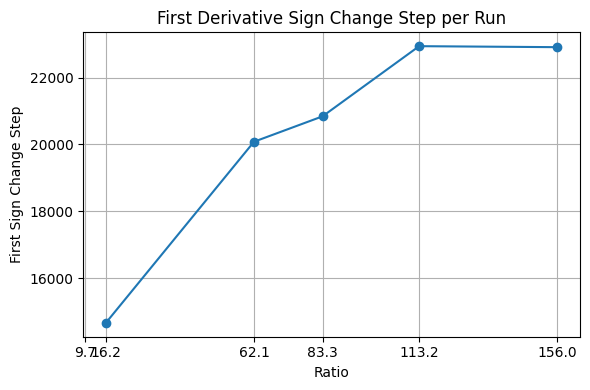

In [7]:

plt.figure(figsize=(6, 4))
plt.plot(ratios[choice], results, marker='o')
plt.xticks(ratios[choice])
plt.xlabel("Ratio")
plt.ylabel("First Sign Change Step")
plt.title("First Derivative Sign Change Step per Run")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
choice = 'fp6_e2m3_fp6_e3m2'
csv_files = glob.glob(f"data/grad_norm/{choice}/*.csv")  

In [5]:

def moving_average(series, window=50):
    return series.rolling(window=window, min_periods=1).mean()

def numerical_derivative(series):
    return series.diff().fillna(0)

# where derivative changes sign, ignoring first X steps
def find_sign_changes(series, ignore_initial=120):
    derivative_sign = np.sign(series)
    sign_changes = derivative_sign.diff().fillna(0).ne(0)
    sign_change_indices = sign_changes[ignore_initial:].index[sign_changes[ignore_initial:]].tolist()
    return sign_change_indices

/tmp/ipykernel_3946401/1249790630.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(csv_files))


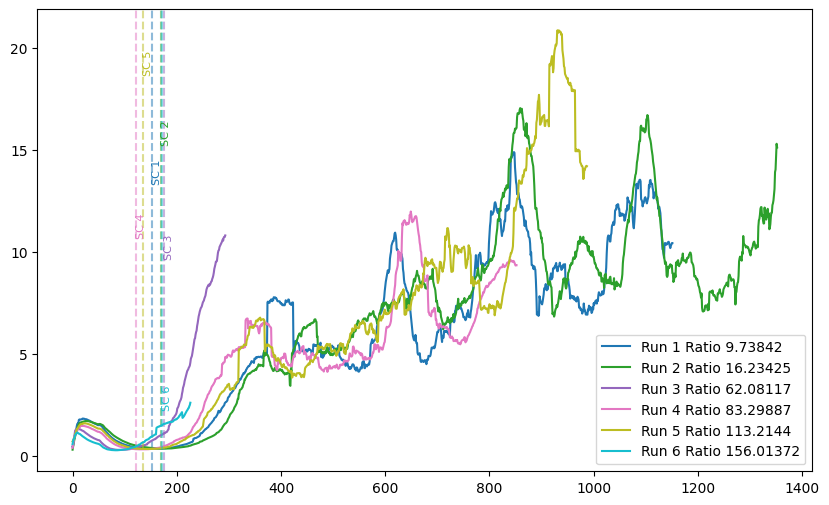

In [6]:
results = []
colors = cm.get_cmap('tab10', len(csv_files))

plt.figure(figsize=(10, 6))
for idx, file in enumerate(sorted(csv_files)):
    df = pd.read_csv(file)

    step_col = "Step"
    # loss_col = [col for col in df.columns if "CrossEntropyLoss" in col and "__" not in col][0]
    # losses = df[loss_col].astype(float).values
    smoothed_grad_norm = moving_average(df[f'{choice} - optim/total_grad_norm'])
    # smoothed = moving_average(losses, window_size)
    grad_norm_derivative = numerical_derivative(smoothed_grad_norm)
    sign_changes = find_sign_changes(grad_norm_derivative)

    label = f"Run {idx + 1} Ratio {ratios[choice][idx]}"
    color = colors(idx)
    plt.plot(smoothed_grad_norm, label=label, color=color)

    if sign_changes:
        first_change = sign_changes[0]
        plt.axvline(x=first_change, color=color, linestyle='--', alpha=0.5)
        plt.text(first_change, max(smoothed_grad_norm) * 0.9, f'SC {idx+1}', rotation=90, color=color, fontsize=8)

    results.append(sign_changes[0])
    # plt.plot(sign_changes, smoothed, label=label)

plt.legend()

In [31]:
results

[136, 206, 228, 124]

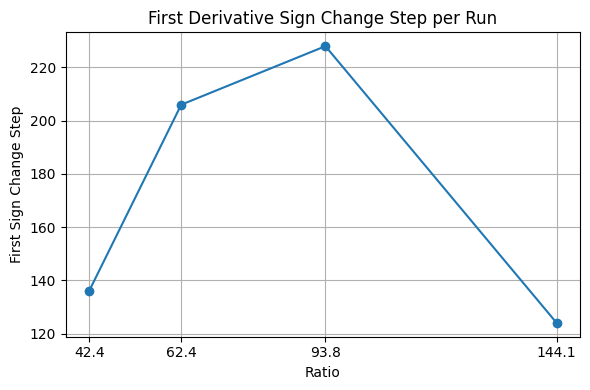

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(ratios[choice], results, marker='o')
plt.xticks(ratios[choice])
plt.xlabel("Ratio")
plt.ylabel("First Sign Change Step")
plt.title("First Derivative Sign Change Step per Run")
plt.grid(True)
plt.tight_layout()
plt.show()

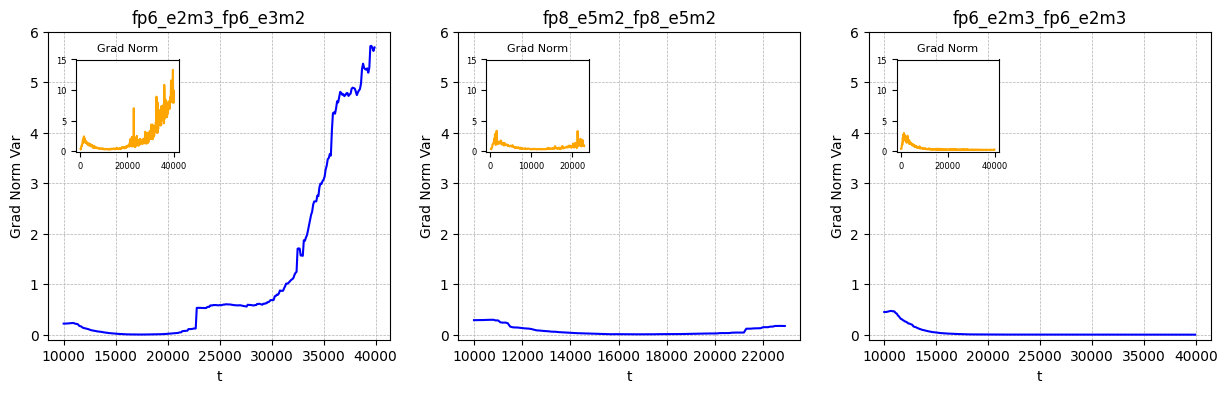

In [6]:

# var(grad_norm) vs. t
K = 100  # Window size for variance
# steps = df["Step"].values
# grad_norms = df[f"{choice} - optim/total_grad_norm"].astype(float).values

# Compute rolling variance
# rolling_var = pd.Series(grad_norms).rolling(window=K).var().values

# Mask the first K-1 values since they will be NaN
# valid_steps = steps[K-1:]
# valid_vars = rolling_var[K-1:]
choices = ['fp6_e2m3_fp6_e3m2', 'fp8_e5m2_fp8_e5m2', 'fp6_e2m3_fp6_e2m3']

# loss_csv_files = sorted(glob.glob(f"data/training_loss/{choice}/*.csv")  )
ncols = 3
nrows = 1 # math.ceil(len(grad_csv_files) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
plt.subplots_adjust(hspace=0.4)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, c in enumerate(choices):
    df_grad = pd.read_csv(f"data/same_FLOPs_ratio/{c}.csv")

    # Extract step and values
    grad_steps = df_grad["Step"].astype(int).values
    grad_norms = df_grad[f'{c} - optim/total_grad_norm'].astype(float).values

    # Compute rolling variance
    grad_var = pd.Series(grad_norms).rolling(window=K).var().values
    # valid = ~np.isnan(grad_var)
    grad_steps_valid = grad_steps[K-1:]
    grad_var_valid = grad_var[K-1:]


    # Plot in log-log scale
    ax = axes[i]
    # ax.loglog(x_vals, y_vals, 'o', markersize=3, alpha=0.7)
    ax.plot(grad_steps_valid, grad_var_valid, label=f'Rolling Variance (K={K})', color='blue')
    ax.set_title(f"{c}")
    ax.set_xlabel("t")
    ax.set_ylabel("Grad Norm Var")
    ax.grid(True, which='both', ls='--', linewidth=0.5)
    ax.set_ylim(-0.1, 6)  # Apply same y-limits

    inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=2)
    inset_ax.plot(grad_steps, grad_norms, color='orange')
    inset_ax.set_title("Grad Norm", fontsize=8)
    inset_ax.tick_params(labelsize=6)
    inset_ax.set_ylim(-0.1, 15)  # Apply same y-limits


In [11]:
import wandb
import pandas as pd

# Set these to your W&B account and project
entity = "harvardml"
project = "test-precision-MX-fineweb"

api = wandb.Api()

prefix = "fp6_e3m2_fp6_e3m2"
runs = api.runs(f"{entity}/{project}",
                filters={"display_name": {"$regex": f"^{prefix}"}}
                )

all_data = []

for run in runs:
        try:
            history = run.history(
                keys=["train/CrossEntropyLoss", "optim/total_grad_norm"], 
                pandas=True,
            )
            
            all_data.append({
                "run_id": run.id,
                "run_name": run.name,
                "ratio": run.config.get("ratio", None),
                "loss_curve": history["train/CrossEntropyLoss"].tolist(),
                "grad_norm_curve": history["optim/total_grad_norm"].tolist()
            })
        except Exception as e:
            print(f"Failed to get history for run {run.id}: {e}")

# Combine all into one DataFrame
df = pd.DataFrame(all_data)

# Save to CSV (optional)
df.to_csv("train_loss_all_runs.csv", index=False)

print("Train loss data extracted for all runs.")

Train loss data extracted for all runs.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with your actual training data)
# D_N_ratios: list of D/N ratios (e.g., [0.25, 0.5, 1.0])
# losses: list of np.arrays, each representing training loss over time for one D/N
# grad_norms: list of np.arrays, each representing grad norm over time for one D/N
# time: np.array of time steps (shared across all curves)


time = np.linspace(0, 1000, 200)  # Assume 200 time steps

# Generate dummy data (replace with your actual data)
np.random.seed(0)
losses = [np.exp(-time / (100 * (d_n + 0.5))) + 0.05 * np.random.randn(len(time)) for d_n in D_N_ratios]
grad_norms = [1 / (1 + np.exp(-(time - 500) / (50 * (d_n + 0.5)))) + 0.1 * np.random.randn(len(time)) for d_n in D_N_ratios]

# Define a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(D_N_ratios)))

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Left subplot: Training Loss
for i, (loss, d_n) in enumerate(zip(losses, D_N_ratios)):
    axs[0].plot(time, loss, label=f'D/N={d_n}', color=colors[i])
axs[0].set_title('Unstable FP8 Training Loss')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Right subplot: Gradient Norms
for i, (grad, d_n) in enumerate(zip(grad_norms, D_N_ratios)):
    axs[1].plot(time, grad, label=f'D/N={d_n}', color=colors[i])
axs[1].set_title('Gradient Norm Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Gradient Norm')
axs[1].legend()

plt.tight_layout()
plt.show()

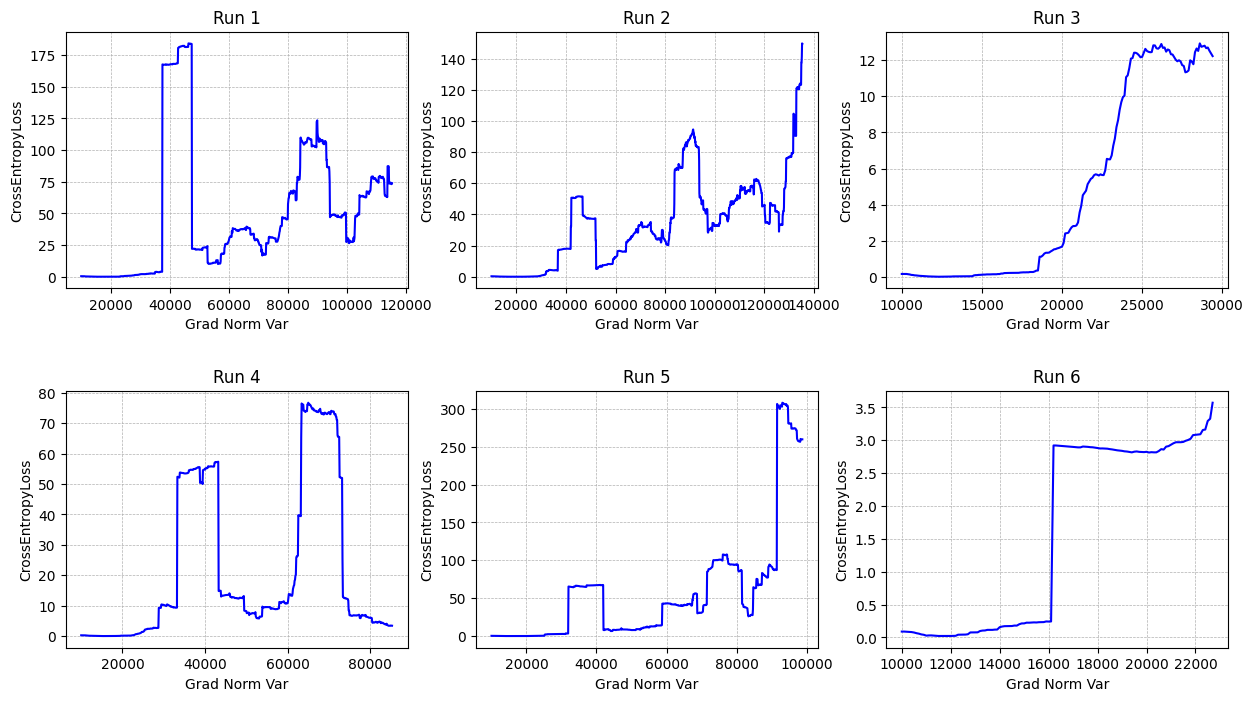

In [ ]:
# var(grad_norm) vs. t
df = pd.read_csv(file)

K = 100  # Window size for variance

# Load data

# steps = df["Step"].values
# grad_norms = df[f"{choice} - optim/total_grad_norm"].astype(float).values

# Compute rolling variance
# rolling_var = pd.Series(grad_norms).rolling(window=K).var().values

# Mask the first K-1 values since they will be NaN
# valid_steps = steps[K-1:]
# valid_vars = rolling_var[K-1:]

grad_csv_files = sorted(glob.glob(f"data/grad_norm/{choice}/*.csv")  )
loss_csv_files = sorted(glob.glob(f"data/training_loss/{choice}/*.csv")  )
ncols = 3
nrows = math.ceil(len(loss_csv_files) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
plt.subplots_adjust(hspace=0.4)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, (loss_file, grad_file) in enumerate(zip(loss_csv_files, grad_csv_files)):
    df_grad = pd.read_csv(grad_file)

    # Extract step and values
    grad_df = df_grad[df_grad["Step"] % 100 == 0].copy()
    grad_steps = grad_df["Step"].astype(int).values
    grad_norms = grad_df[f'{choice} - optim/total_grad_norm'].astype(float).values

    # Compute rolling variance
    grad_var = pd.Series(grad_norms).rolling(window=K).var().values
    # valid = ~np.isnan(grad_var)
    grad_steps_valid = grad_steps[K-1:]
    grad_var_valid = grad_var[K-1:]


    # Plot in log-log scale
    ax = axes[i]
    # ax.loglog(x_vals, y_vals, 'o', markersize=3, alpha=0.7)
    ax.plot(grad_steps_valid, grad_var_valid, label=f'Rolling Variance (K={K})', color='blue')
    ax.set_title(f"Run {i + 1}")
    ax.set_xlabel("Grad Norm Var")
    ax.set_ylabel("CrossEntropyLoss")
    ax.grid(True, which='both', ls='--', linewidth=0.5)

    

# Plot
# plt.figure(figsize=(10, 5))
# plt.plot(valid_steps, valid_vars, label=f'Rolling Variance (K={K})', color='blue')
# plt.xlabel("Step")
# plt.ylabel(f"Variance of Grad Norm (last {K} steps)")
# plt.title("Variance of Gradient Norm over Time")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

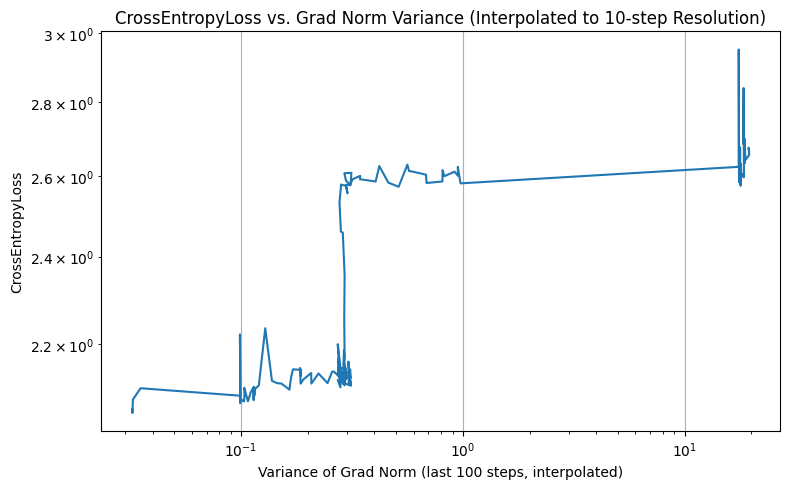

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K = 100

# Load data
df = pd.read_csv(f"data/grad_norm/{choice}/wandb_grad_norm_{choice}_144.csv")  # replace with your actual file
steps = df["Step"].values
grad_norms = df[f"{choice} - optim/total_grad_norm"].astype(float).values

# Compute rolling variance
rolling_var = pd.Series(grad_norms).rolling(window=K).var().values

df_loss = pd.read_csv(f"data/training_loss/{choice}/wandb_export_{choice}_4.csv")

# Extract series
loss_steps = df["Step"].astype(int).values
losses = df_loss[f"{choice} - train/CrossEntropyLoss"].astype(float).values
losses = losses[::10][:-1]

# Interpolate grad norm variance to match loss_steps

# valid_steps = steps[K-1:]
# valid_vars = rolling_var[K-1:]
# losses = losses[K-1:]

grad_csv_files = sorted(glob.glob(f"data/grad_norm/{choice}/*.csv")  )
loss_csv_files = sorted(glob.glob(f"data/training_loss/{choice}/*.csv")  )
ncols = 3
nrows = math.ceil(len(loss_csv_files) / ncols)

for i, (loss_file, grad_file) in enumerate(zip(loss_csv_files, grad_csv_files)):
    df_loss = pd.read_csv(loss_file)
    df_grad = pd.read_csv(grad_file)

    # Extract step and values
    loss_steps = df_loss["Step"].astype(int).values
    losses = df_loss[f'{choice} - train/CrossEntropyLoss'].astype(float).values

    grad_df = df_grad[df_grad["Step"] % 100 == 0].copy()
    grad_steps = grad_df["Step"].astype(int).values
    grad_norms = grad_df[f'{choice} - optim/total_grad_norm'].astype(float).values

    # Compute rolling variance
    grad_var = pd.Series(grad_norms).rolling(window=K).var().values
    # valid = ~np.isnan(grad_var)
    grad_steps_valid = grad_steps[K-1:]
    grad_var_valid = grad_var[K-1:]


    # Plot in log-log scale
    ax = axes[i]
    # ax.loglog(x_vals, y_vals, 'o', markersize=3, alpha=0.7)
    ax.plot(grad_steps_valid, grad_var_valid, label=f'Rolling Variance (K={K})', color='blue')
    ax.set_title(f"Run {i + 1}")
    ax.set_xlabel("Grad Norm Var")
    ax.set_ylabel("CrossEntropyLoss")
    ax.grid(True, which='both', ls='--', linewidth=0.5)

# plt.figure(figsize=(8, 5))
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(valid_vars[100:], losses[100:],)
# plt.xlabel(f"Variance of Grad Norm (last {K} steps, interpolated)")
# plt.ylabel("CrossEntropyLoss")
# plt.title("CrossEntropyLoss vs. Grad Norm Variance (Interpolated to 10-step Resolution)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()